<a href="https://colab.research.google.com/github/ruthsbel/bananos-redes-convolucionales/blob/main/Proyecto_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Montamos el dataset sel drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


* Se definen 350 muestras para entrenamiento y 50 para testeo
* Aplicamos un SubsetRandomSampler del 20% del tamaño de nuestro set de testeo

In [ ]:
from torch.utils.data import SubsetRandomSampler
from torchvision import datasets, transforms
from fastdownload import download_url
from fastai.vision.all import *
import numpy as np
from fastcore.all import *

# Definicion de transformadas para set de entrenamiento
# Se aplica un resize de las imagenes a 120px y se normaliza a 0.5
# Como data augmentation se hace un randomFlip
train_transforms = transforms.Compose([transforms.Resize(size=(120,120)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                       ])

# Definicion de transformadas para set de testeo
# Se aplica un resize de las imagenes a 120px y se normaliza a 0.5

test_transforms = transforms.Compose([ transforms.Resize(size=(120,120)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                       ])

# Se establece el directorio de los archivos
data_dir = "/content/gdrive/MyDrive/DatasetBanano"
train_data = datasets.ImageFolder(data_dir+'/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir+'/test', transform=test_transforms)

# Para obtener un subdataset de validación, se aplica un SubsetRandomSampler del 20% del tamaño de nuestro set de entrenamiento
valid_size=0.2
train_length=len(train_data)
indices=[i for i in range(train_length)]
np.random.shuffle(indices)
split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

# Cargamos los datos para train y valid con el subsampler y para el test directamente desde el directorio.
trainloader=torch.utils.data.DataLoader(train_data,batch_size=64,sampler=train_sampler)
validloader=torch.utils.data.DataLoader(train_data,batch_size=64,sampler=valid_sampler)
testloader=torch.utils.data.DataLoader(test_data,batch_size=100, shuffle=True)

# Se establecen las clases de interes
classes = ['Exportacion','Rechazo']

Se realiza un muestreo y se visualizan las imágenes para validar el correco asignamiento de las categorías.

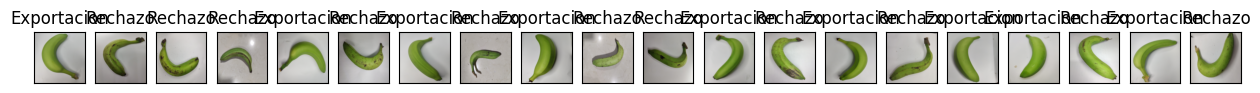

In [ ]:
# En esta celda hacemos una previsualización de los datos que tenemos
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1,2,0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, max(int(len(images)//2), 1), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [ ]:
# Verificamos las dimensiones de nuestro dataset
images.shape

(64, 3, 120, 120)

## Design your Convolutional neural network architecture.
* Se arma la arquictectura de la red neural convolucional
* Aplicamos 3 capas convolucionales con una capa de de max pooling para reducir dimensionalidad
* Definimos capas lineales para el flattening y dropout para evitar un posible overfitting
* Utilizamos Relu para que el modelo pueda desarrollar mejor y aprenda más rápido

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Armamos la red convolucional
# Vamos a establecer 3 capas convolucionales, capa de max pooling para reducir dimensionalidad
# Capas lineales para la parte del flattening y dropout para evitar el overfitting

# Nuestro batch size es de 64

# Flujo

# (64 x 3 x 120x120) -> conv1/maxPool -> (64 x 16 x 60x60) -> conv2/maxPool -> (64 x 32 x 30x30) -> conv3/maxPool -> (64 x 64 x 15x15) -> Flat -> (64x15x15)-> fc1 -> (100)->fc2 -> (2)

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3,16,3,padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(64*15*15, 100)
    self.fc2 = nn.Linear(100,2)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.dropout(x)
    x = x.view(-1,64*15*15)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = Net()
print(model)
# Vamos a entrenar con gpu
model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
torch.save(model,"/content/model.pt")

## Define the model´s hyper-parameters.
* Establecemos el criterio de CrossEntropyLoss lo que nos permite asegurar tener probabilidades al final de la red
* Trabajamos con Adam y un learning rate de 0.001, para nuestro caso este fue el mejor rate ya que con otros valores no se obtuvieron mejores resultados
* Definimos un epoch de 15, siendo el mejor valor para nuestro modelo

In [ ]:
import torch.optim as optim

# Establecemos el criterio de CrossEntropyLoss, esto nos asegura tener probabilidades al final de la red
criterion = nn.CrossEntropyLoss()

# Optimizador adam con un learning rate de 0.001. Se hicieron pruebas con otros LR pero no dieron buenos resultados
optimizer = optim.Adam(model.parameters(), lr= 0.01)
# Numero de epochs a entrenar
n_epochs = 15

## Train and validate your model from zero.

In [ ]:
valid_loss_min = np.inf
# Empieza proceso de entrenamiento
for epoch in range(1,n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  model.train()
  for batch_idx, (data,target) in enumerate(trainloader):
    data,target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

  model.eval()
  for batch_idx, (data,target) in enumerate(validloader):
    data,target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item() * data.size(0)



  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)
  print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch,train_loss, valid_loss))

# Aplicaremos el concepto de guardar el mejor modelo de validación para evitar el overfitting

  if (valid_loss <= valid_loss_min):
    print("Error de validación fue mejor, guardando modelo {:.6f} -> {:.6f}".format(valid_loss_min,valid_loss))
    torch.save(model.state_dict(),"mejormodelo.pt")
    valid_loss_min = valid_loss


## Is underfitting, overfitting or right?.

* En este resultado podemos ver que con más epocas (alrededor de 15) el modelo sigue aprendiendo frente al dataset de entrenamiento pero no mejora en el de validación, **en cambio empeora**, lo cual implica un claro overfitting, esto justifica el guardar el mejor modelo de validacion para luego aplicarlo.
* Esto puede deberse a que no tenemos tantos datos para nuestro entrenamiento. El uso de un dataset mas limpio y con mas validaciones mejoraría nuestros datos. Se hicieron varias pruebas cambiando el learning rate y el numero de epochs, pero se dejo con 30 para demostrar que pasado los 15 epochs el modelo no se mejora.

## Test your model

In [ ]:
model.load_state_dict(torch.load("modelo3.pt"))
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
model.eval()

for data,target in testloader:
  data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output,target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output,1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())

  for i in range(100):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(testloader.dataset)
print("Perdida de test: {:.6f}\n".format(test_loss))

for i in range(2):
  if class_total[i]>0:
    print("Accuracy de prueba para %5s: %2d%% (%2d/%2d)" % (classes[i], 100 * class_correct[i]/ class_total[i],
                                                     np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print("Accuracy de prueba para %5s: N/A (no hubo muestras)" % classes[i])

print("\nAccuracy total para la prueba: %2d%% (%2d/%2d)" % (
    100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Perdida de test: 0.701631

Accuracy de prueba para Exportacion: 64% (32/50)
Accuracy de prueba para Rechazo: 50% (25/50)

Accuracy total para la prueba: 57% (57/100)


In [ ]:
! pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=055356c6608f72f324075e90761816027b6f96751577a81ca38fb75693da5d72
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


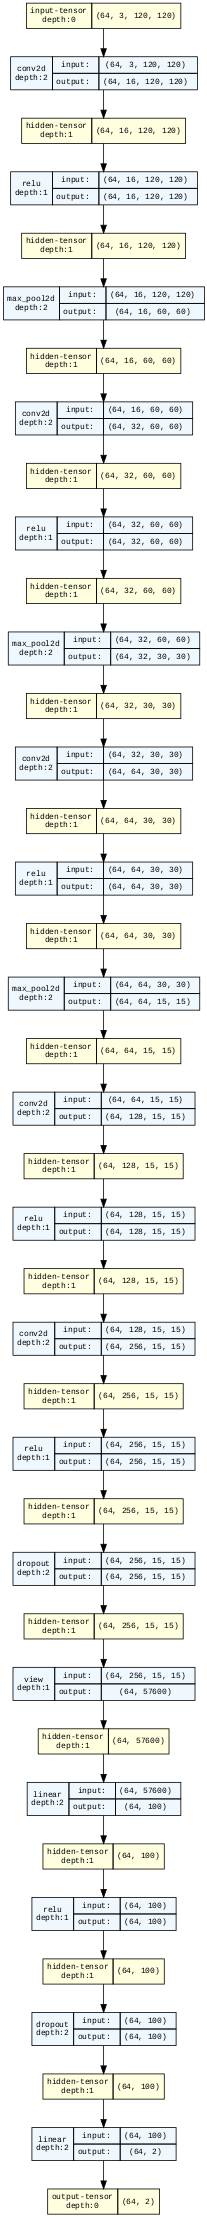

In [ ]:
import torchvision
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph_1 = draw_graph(
    Net(), input_size=(64, 3, 120, 120),
    graph_name='MLP',
    hide_inner_tensors=False,
    hide_module_functions=False,
)
model_graph_1.visual_graph

La siguiene imágen muestra un resumen de los resultados obtenidos con los tres modelos que trabajamos:
* El enfoque del modelo de clasificación es identificar la mayor cantidad de bananos de rechazo, ya que eso influye más en el modelo de negocio de las bananeras según lo planteado en el proyecto.
* Con esta premisa, seleccionamos el modelo que tenga el mejor accuracy para identificar banano de rechazo.
* El modelo A que representa una red de 3 capas convolucionales nos ofrece una mejor accuracy que el resto de modelos.


<img src="https://i.ibb.co/JmC63GN/dc02d8f6-5741-4abe-8213-b47ee95e4f7b.png" />